# Generative adversarial network(GAN)

## Introduction

A generative adversarial network is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in June 2014. Two neutral networks contest with each other in a game (in the form of a zero-sum game, where one agent's gain is another agent's loss) and finally generate a "high quality" fake result.

### GAN model

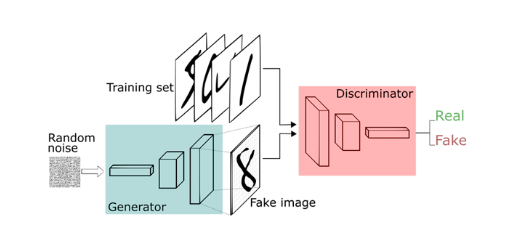

In a GAN, we need to defined two model: "Generator" and "Discriminator", and they have different task.
Take generating a fake face picture as example:
Generator need to generate a fake picture that will not be detected by discriminator<br>

Discriminator need to detect fake picture, it outputs a probability close to 1 if i it thinks the picture is real, close to 0 otherwise.

If everything goes on well, we will get a "skillful" generator and a "careful" Discriminator.

Combat is the core of GAN, We don't use the data to judge if we have got a good model, instead, we use another model to judge it, or to say, use fight to judge the ability.

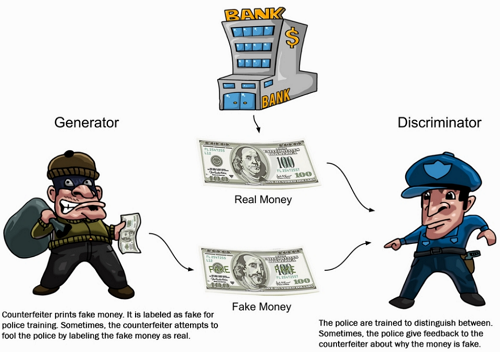

## Mathematical insight

Loss function of discriminator (to maximize)
$$ 1/m \sum_{i=1}^m [log(D(x^i))+log(1-D(G(z^i)))] $$

Loss function of Generator: (to minimize)
$$ 1/m \sum_{i=1}^m log(1-D(G(z^i))) $$


$D(x^i)$ is  Discriminator <br>
Take an image as input : x <br>
Output a probability close to 1 if it thinks the image is real 0 if it thinks it is fake

$G(z^i)$ is  generator<br>
take a vector in input : z (noise) <br>
output an image

Put it together 
$$ \min\limits_{G}\  \max\limits_{D}\ L(D,G)\ = E_{x \sim p_{data}(x)}[log D(x)]+E_{z\sim p_z(z)}[log(1-D(G(z)))]   $$
where: <br>
x : real data <br>
z : noise <br>
We want to maximize with respect to D : indeed $log(D(x))$ should be equal to 0 and $log(D(G(z))$ close to 0 if the discrimanator is efficient, thus $L(D,G)$ converge toward 0 <br>

Then we want to minimize with respect to G : G should fool the discriminator thus $D(G(z))$ should be 1 and $log(1-D(G(z))$ converging to minus infinity <br> 

In pratice while trying to min$log(1-D(G(z))$ we face vanishing gradient issue, we instead max$log(D(G(z)))$ as we want $log(D(G(z)))$ close to 0 <br>


We will use the BCEloss: [Offical document](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
it calculate :
$$l_n=-1*[y_n \bullet log(x_n)+(1-y_n) \bullet log(1-x_n)]$$



In [17]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

In [18]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

### Model setting

In [19]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))


## hyperparameters

In [20]:
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

The data we chose is MNIST dataset, it includes the pictures of handwriting digits,which has a training set of 60,000 examples and 10,000 examples.

## Training process

In [26]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

n_epoch = 100
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
"""
#########Show loss and fake picture############
    plt.figure(figsize=(20,3))
    plt.subplot(1,2,1)
    plt.plot(LossD_list,label="Loss of discriminator")
    plt.xlabel('number of training example')
    plt.ylabel('Loss')
    plt.plot(LossG_list,label="Loss of generator")
    plt.title('Loss of each training example')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(LossD_list_big,label="Loss of discriminator")
    plt.plot(LossG_list_big,label="Loss of generator")
    plt.xlabel('number of epoches')
    plt.ylabel('loss')
    plt.title('Average loss of each Training epoch')
    plt.legend()
    

    plt.figure(figsize=(25, 5))
    for i in range(16):
        plt.subplot(1,16,i+1)
        plt.imshow(fake[i])
    plt.show()"""
        

[1/100]: loss_d: 1.276, loss_g: 0.896
[2/100]: loss_d: 1.281, loss_g: 0.877
[3/100]: loss_d: 1.287, loss_g: 0.874
[4/100]: loss_d: 1.283, loss_g: 0.885
[5/100]: loss_d: 1.283, loss_g: 0.890
[6/100]: loss_d: 1.284, loss_g: 0.882
[7/100]: loss_d: 1.289, loss_g: 0.882
[8/100]: loss_d: 1.280, loss_g: 0.893
[9/100]: loss_d: 1.281, loss_g: 0.887
[10/100]: loss_d: 1.284, loss_g: 0.879
[11/100]: loss_d: 1.280, loss_g: 0.888
[12/100]: loss_d: 1.289, loss_g: 0.870
[13/100]: loss_d: 1.289, loss_g: 0.879
[14/100]: loss_d: 1.283, loss_g: 0.904
[15/100]: loss_d: 1.281, loss_g: 0.884
[16/100]: loss_d: 1.282, loss_g: 0.886
[17/100]: loss_d: 1.280, loss_g: 0.888
[18/100]: loss_d: 1.281, loss_g: 0.878
[19/100]: loss_d: 1.287, loss_g: 0.871
[20/100]: loss_d: 1.290, loss_g: 0.868
[21/100]: loss_d: 1.286, loss_g: 0.876
[22/100]: loss_d: 1.283, loss_g: 0.887
[23/100]: loss_d: 1.281, loss_g: 0.894
[24/100]: loss_d: 1.282, loss_g: 0.882
[25/100]: loss_d: 1.288, loss_g: 0.870
[26/100]: loss_d: 1.283, loss_g: 0

'\n#########Show loss and fake picture############\n    plt.figure(figsize=(20,3))\n    plt.subplot(1,2,1)\n    plt.plot(LossD_list,label="Loss of discriminator")\n    plt.xlabel(\'number of training example\')\n    plt.ylabel(\'Loss\')\n    plt.plot(LossG_list,label="Loss of generator")\n    plt.title(\'Loss of each training example\')\n    plt.legend()\n    plt.subplot(1,2,2)\n    plt.plot(LossD_list_big,label="Loss of discriminator")\n    plt.plot(LossG_list_big,label="Loss of generator")\n    plt.xlabel(\'number of epoches\')\n    plt.ylabel(\'loss\')\n    plt.title(\'Average loss of each Training epoch\')\n    plt.legend()\n    \n\n    plt.figure(figsize=(25, 5))\n    for i in range(16):\n        plt.subplot(1,16,i+1)\n        plt.imshow(fake[i])\n    plt.show()'

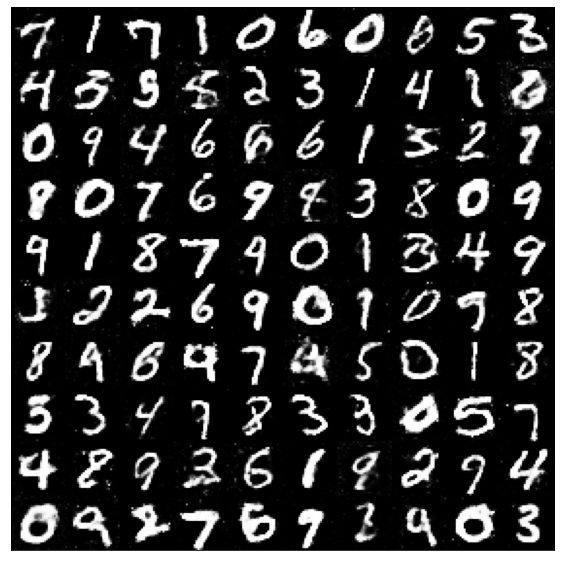

In [32]:
def sample(G,z_dim):
    with torch.no_grad():
        # sample a Gaussian random vector with zero mean and identity covariance matrix
        z = torch.randn(1,z_dim).to(device)
        # pass it through the decoder
        x = G(z).reshape(28,28).cpu()
    return x
    

n_grid = 10
X_gen = np.zeros((n_grid, n_grid, 28, 28))

for i in range(n_grid):
        for j in range(n_grid):
            X_gen[i,j,:,:] = sample(G, z_dim)
            
def display_digits(X, digit_size=28, n_i=20, n_j=20, figsize=(20, 20)):
    
    figure = np.zeros((digit_size * n_i, digit_size * n_j))
    
    for i in range(n_i):
        for j in range(n_j):            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = X[i,j,:,:]
    
    plt.figure(figsize=figsize)
    plt.imshow(figure, cmap='Greys_r')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()    
display_digits(X_gen, n_i=10, n_j=10, figsize=(10, 10))


In [36]:
FILE = "model_gen2.pth"
torch.save(G.state_dict(), FILE)
FILE2 = "model_disc.pth"
torch.save(D.state_dict(), FILE2)

In [37]:
FILE1 = "model_gen2.pth"
gen_load = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
gen_load.load_state_dict(torch.load(FILE1))
gen_load.eval()

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

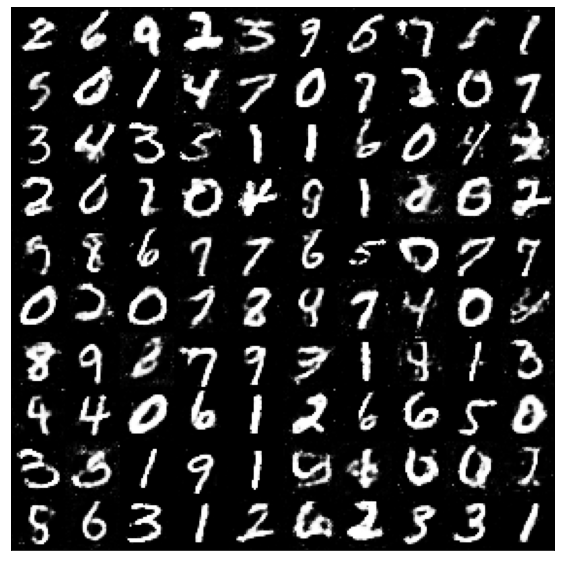

In [39]:
def sample(G,z_dim):
    with torch.no_grad():
        # sample a Gaussian random vector with zero mean and identity covariance matrix
        z = torch.randn(1,z_dim).to(device)
        # pass it through the decoder
        x = G(z).reshape(28,28).cpu()
    return x
    

n_grid = 10
X_gen = np.zeros((n_grid, n_grid, 28, 28))

for i in range(n_grid):
        for j in range(n_grid):
            X_gen[i,j,:,:] = sample(gen_load, z_dim)
            
def display_digits(X, digit_size=28, n_i=20, n_j=20, figsize=(20, 20)):
    
    figure = np.zeros((digit_size * n_i, digit_size * n_j))
    
    for i in range(n_i):
        for j in range(n_j):            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = X[i,j,:,:]
    
    plt.figure(figsize=figsize)
    plt.imshow(figure, cmap='Greys_r')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()    
display_digits(X_gen, n_i=10, n_j=10, figsize=(10, 10))